##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a stateful RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c07_forecasting_with_stateful_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c07_forecasting_with_stateful_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

2023-02-23 07:58:38.932996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

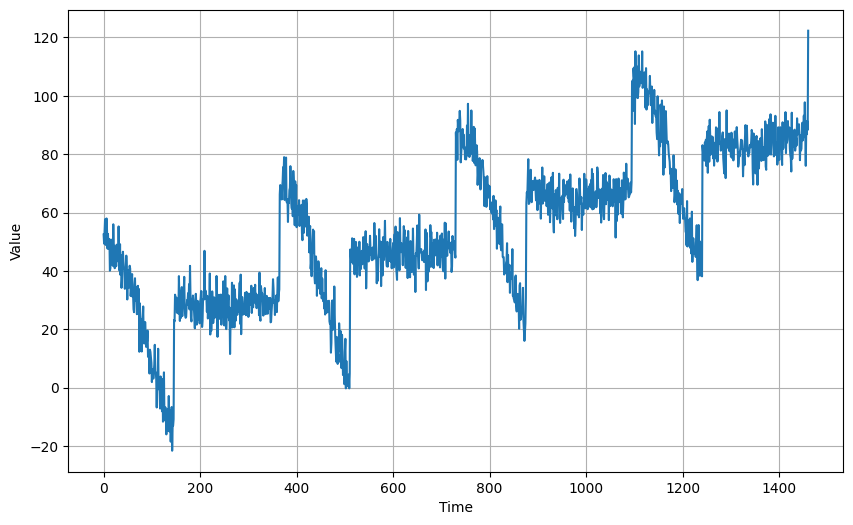

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Stateful RNN Forecasting

In [6]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [7]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


2023-02-23 07:58:45.412707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 2s 21ms/step - loss: 198.1908 - mae: 198.6908 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 6ms/step - loss: 150.4696 - mae: 150.9696 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 5ms/step - loss: 99.8385 - mae: 100.3380 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 69.8402 - mae: 70.3391 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 9ms/step - loss: 56.1360 - mae: 56.6322 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 51.3386 - mae: 51.8362 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 5ms/step - loss: 48.9237 - mae: 49.4217 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 6ms/step - loss: 46.7915 - mae: 47.2891 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 0s 6ms/step - loss: 44.5203 - mae: 45

(1e-08, 0.0001, 0.0, 30.0)

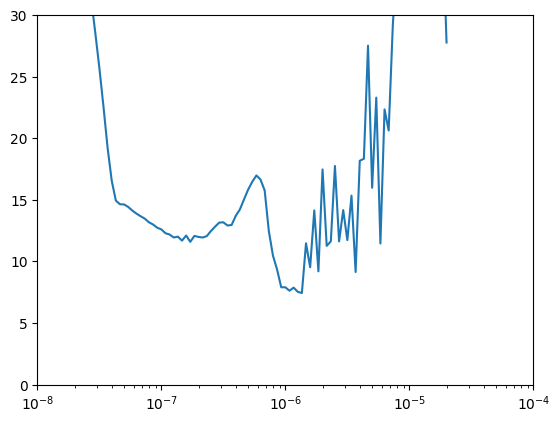

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 2s 18ms/step - loss: 55178.0859 - mae: 55178.5859 - val_loss: 81780.6094 - val_mae: 81781.1094
Epoch 2/500
33/33 [==============================] - 0s 10ms/step - loss: 41176.3828 - mae: 41176.8789 - val_loss: 50284.8867 - val_mae: 50285.3867
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 72465.0234 - mae: 72465.5234 - val_loss: 157328.1094 - val_mae: 157328.6250
Epoch 4/500
33/33 [==============================] - 0s 8ms/step - loss: 51301.1445 - mae: 51301.6445 - val_loss: 72010.0312 - val_mae: 72010.5312
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 23992.9688 - mae: 23993.4648 - val_loss: 9685.9326 - val_mae: 9686.4307
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 35957.4648 - mae: 35957.9609 - val_loss: 25794.0918 - val_mae: 25794.5918
Epoch 7/500
33/33 [==============================] - 0s 8ms/step - loss: 38264.7031 - mae: 38265.1953 - val_loss: 13

In [12]:
model = keras.models.load_model("my_checkpoint.h5")

In [13]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 0s 286ms/step


In [14]:
rnn_forecast.shape

(461,)

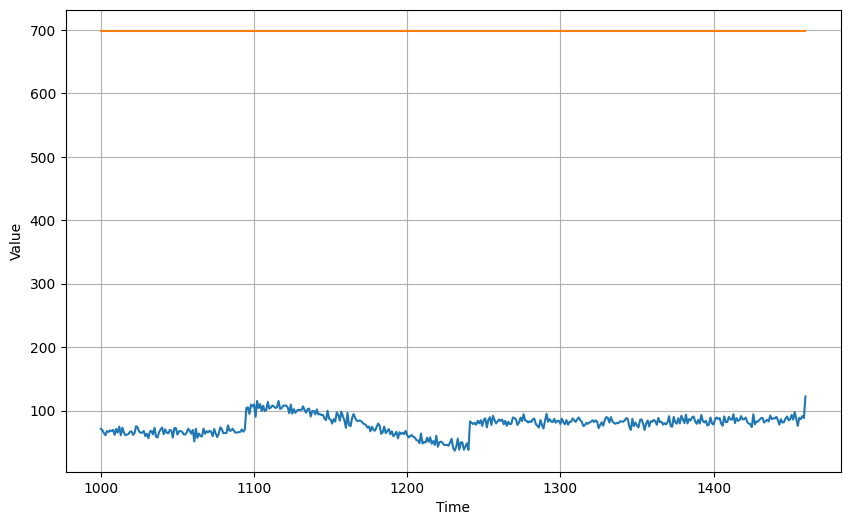

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

620.14453

# Mechanized Stateful RNN

In [17]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism


In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

gaussian_model = MechanizedSequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
gaussian_history = gaussian_model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
In Gaussian Mechanism
In Gaussian Mechanism
33/33 [==============================] - 2s 12ms/step - loss: 161.2093 - mae: 161.7079 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 137.4705 - mae: 137.9721 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 6ms/step - loss: 112.1169 - mae: 112.6185 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 6ms/step - loss: 86.0837 - mae: 86.5844 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 6ms/step - loss: 58.7315 - mae: 59.2294 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 6ms/step - loss: 30.7979 - mae: 31.2966 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 20.5545 - mae: 21.0467 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 9ms/step - loss: 19.2394 - mae: 19.7241 - lr: 1.7113e-08
Epoch 9/100
33/33 [==========================

(1e-08, 0.0001, 0.0, 30.0)

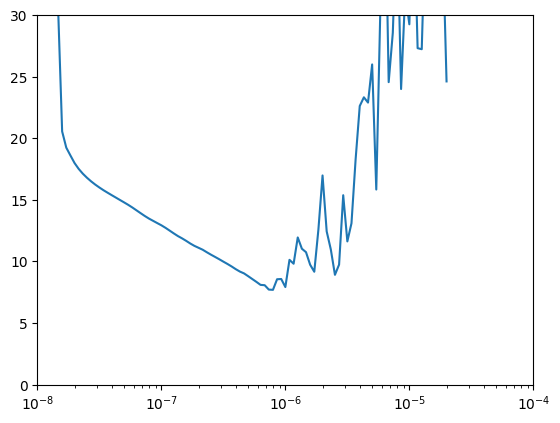

In [19]:
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

gaussian_model = MechanizedSequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
gaussian_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "gaussian_model_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

gaussian_model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, gaussian_model_checkpoint, reset_states])

Epoch 1/500
In Gaussian Mechanism
In Gaussian Mechanism
     28/Unknown - 1s 6ms/step - loss: 31920.6934 - mae: 31921.2051In Gaussian Mechanism
33/33 [==============================] - 2s 17ms/step - loss: 41330.6211 - mae: 41331.1328 - val_loss: 157013.7031 - val_mae: 157014.2188
Epoch 2/500
33/33 [==============================] - 0s 8ms/step - loss: 94944.9297 - mae: 94945.4609 - val_loss: 10111.4688 - val_mae: 10111.9727
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 55705.0000 - mae: 55705.5039 - val_loss: 14899.8545 - val_mae: 14900.3535
Epoch 4/500
33/33 [==============================] - 0s 8ms/step - loss: 54600.9258 - mae: 54601.4297 - val_loss: 114483.0469 - val_mae: 114483.5469
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 44197.1211 - mae: 44197.6172 - val_loss: 3429.2771 - val_mae: 3429.7761
Epoch 6/500
33/33 [==============================] - 0s 8ms/step - loss: 33816.4336 - mae: 33816.9453 - val_loss: 35.4695 - val_m

In [27]:
gaussian_model = keras.models.load_model("gaussian_model_checkpoint.h5",
                                         custom_objects={'MechanizedSequential':MechanizedSequential})

In [28]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

gaussian_model = MechanizedSequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
gaussian_history = gaussian_model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
In Gaussian Mechanism
In Gaussian Mechanism
33/33 [==============================] - 3s 16ms/step - loss: 84.0441 - mae: 84.5431 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 15ms/step - loss: 72.6478 - mae: 73.1479 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 15ms/step - loss: 64.8217 - mae: 65.3242 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 14ms/step - loss: 59.0866 - mae: 59.5869 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 15ms/step - loss: 55.0877 - mae: 55.5852 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 1s 18ms/step - loss: 52.0739 - mae: 52.5700 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 1s 19ms/step - loss: 49.2343 - mae: 49.7338 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 12ms/step - loss: 46.1098 - mae: 46.6081 - lr: 1.7113e-08
Epoch 9/100
33/33 [=========================

In [29]:
gaussian_model.reset_states()
gaussian_rnn_forecast = gaussian_model.predict(series[np.newaxis, :, np.newaxis])
gaussian_rnn_forecast = gaussian_rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 0s 277ms/step


In [30]:
gaussian_rnn_forecast.shape

(461,)

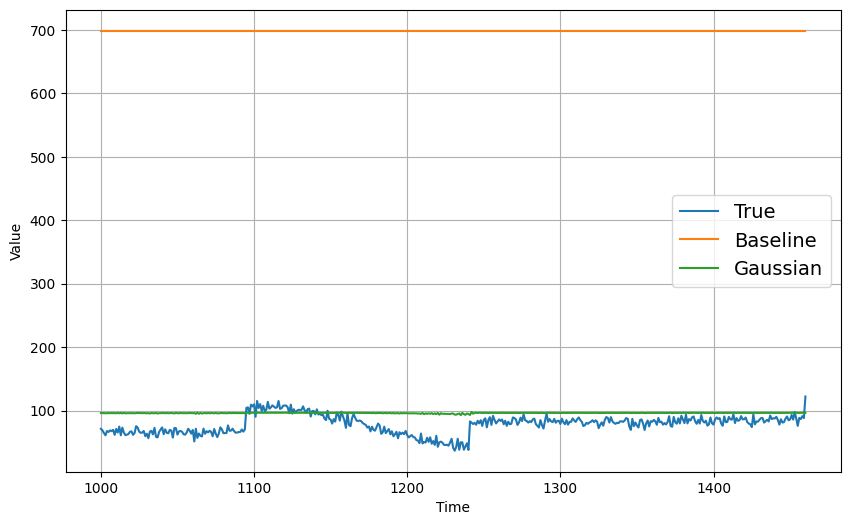

In [31]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")

In [32]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

620.14453

In [33]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()

19.403278